# MNIST Classification with Dense Neural Networks

This notebook is an example of using Dense Neural Networks to classify handwritten digits. The model will be trained and evaluated on the MNIST dataset using TensorFlow.

In [254]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

Tensorflow makes a lot of things much easier for us, one of which is loading datasets. The `tensorflow-datasets` package gives us access to a massive suite of datasets, of which MNIST is one. 

In [255]:
# TFDS's load function fetches the dataset we provide as its first parameter, in this case mnist
# It outputs two objects. The first is a tuple containing the training dataset and testing dataset already separated.
# The second is information about the dataset, such as the size of it and its class names
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    # The split parameter tells tfds to keep the training and testing data separated, returning them as a tuple
    split=['train', 'test'],
    # Not necessary for this dataset, but its good practice to shuffle around all of the data for maximum entropy
    shuffle_files=True,
    # Change the shape of the returned objects, each image is now a tuple with the image itself and its class
    as_supervised=True,
    # Return the info of the dataset as well
    with_info=True,
)

ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/ryan.malley/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

The ds_info object gives us a lot of helpful info. Our dataset is split into 60,000 training examples and 10,000 testing examples. Each image is 28x28 pixels, and each has a numerical label. That label might be a string in other datasets, like "cat" or "dog". 

In [256]:
next(iter(ds_train))[1].numpy()

2024-05-10 17:41:01.325071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-05-10 17:41:01.325356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2024-05-10 17:41:01.346416: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline 

4

## Visualize, Visualize, Visualize

2024-05-10 17:41:01.366923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-05-10 17:41:01.367184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-05-10 17:41:01.385676: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

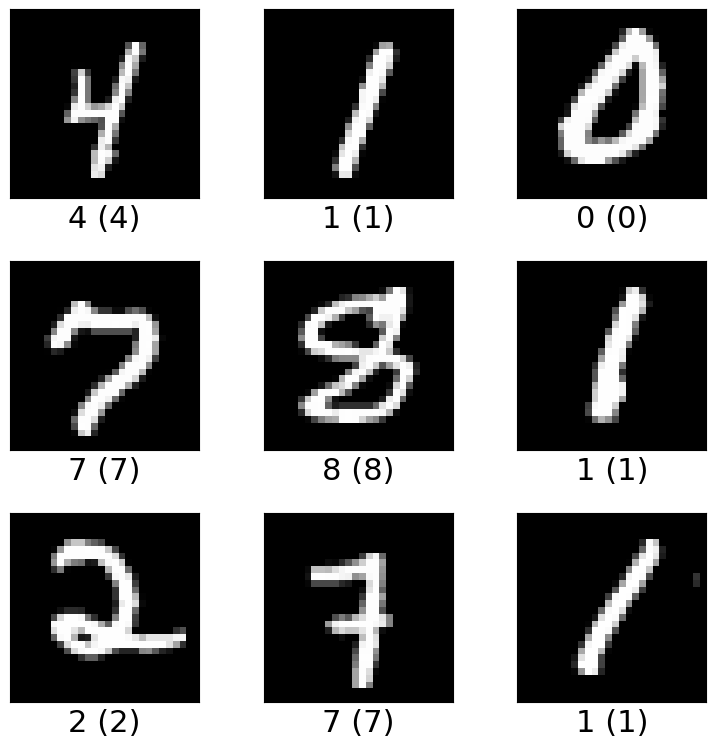

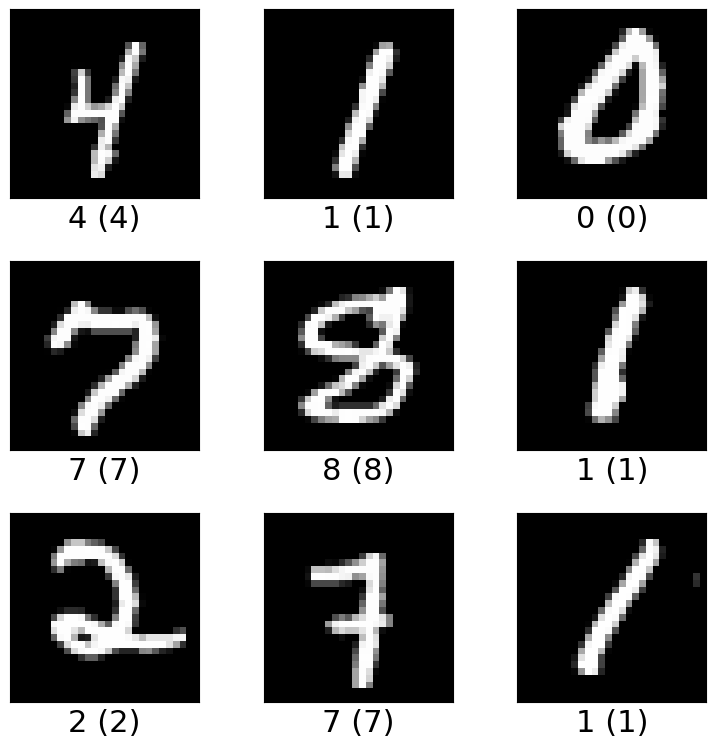

In [257]:
tfds.show_examples(ds_train, ds_info)

This looks familiar, I think we can work with this no problem. But let's get ahead of one important step that we took last time...

2024-05-10 17:41:01.557688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-05-10 17:41:01.557952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]
2024-05-10 17:41:01.575843: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline si

0


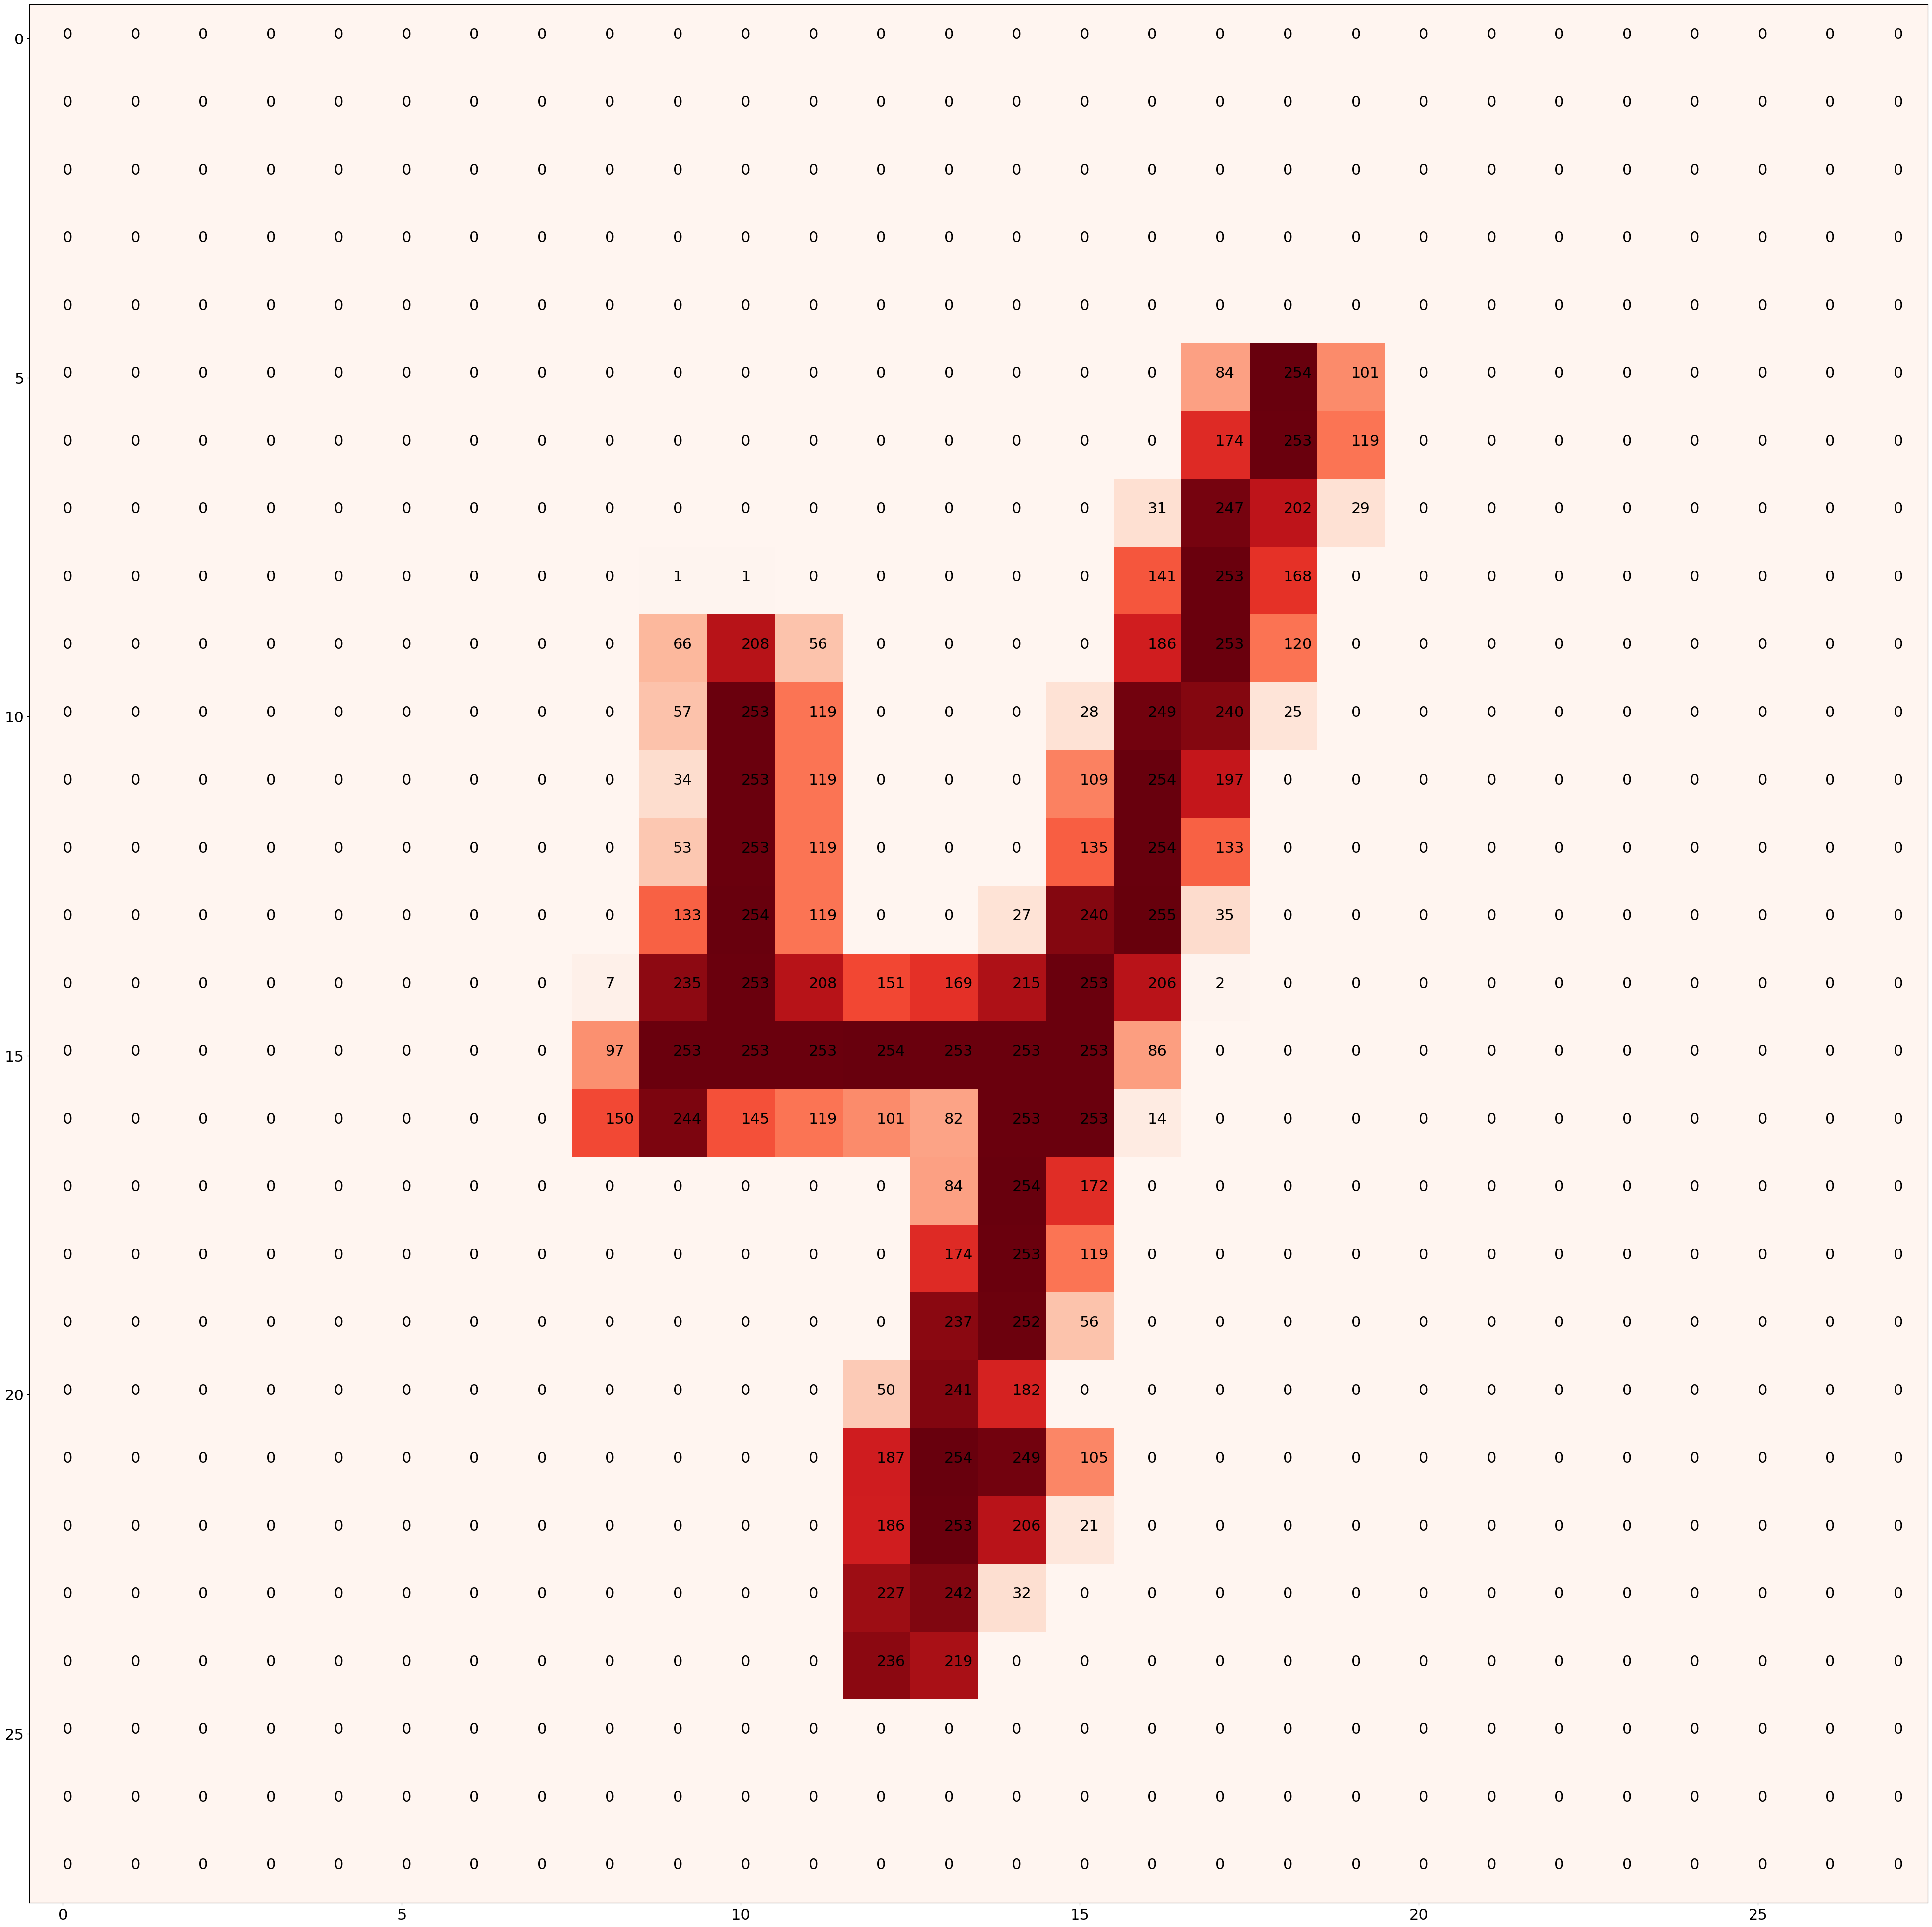

In [258]:
plt.figure(figsize=(50, 50))
image = next(iter(ds_train.take(1)))[0]
print(image[i, j][0].numpy())
fig = plt.imshow(image, cmap='Reds')
# fig.figsize((50, 50))
ax = fig.axes
font = {'size': 22}
plt.rc('font', **font)
for i in range(28):
    for j in range(28):
        text = ax.text(j, i, image[i, j].numpy()[0])

We're back where we were when we had our troubles with K-Means. That means we have to scale things down to values 0 - 1. But we're dealing with tensorflow datasets, so that's going to make things difficult. Except that Tensorflow accounted for this, and gave us functions to make this process a lot easier. We'll also run some quality of life functions over our dataset to improve performance and accuracy.

In [259]:
# This function takes in an image and a label, and then returns a scaled down version that's also a float. 
# We need the label because we're going to overwrite the objects in our dataset, so the label has to be placed back in when we're done
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# The map function takes in a function that you want to apply to all of our datapoints, and performs it for you!
# This function is available in a lot of languages, and is essential for functional programming. 
# Read more about it here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
# Caching helps reduce the time it takes to retrain on an image after the first time
ds_train = ds_train.cache()
# Shuffle changes the order of the training dataset each epoch to prevent overfitting
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
# Batching improves performance
ds_train = ds_train.batch(128)
# While we train on one batch, we want to start pulling the data for the next batch
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

2024-05-10 17:41:03.231158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-05-10 17:41:03.231511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [1]
	 [[{{node Placeholder/_4}}]]


0.0


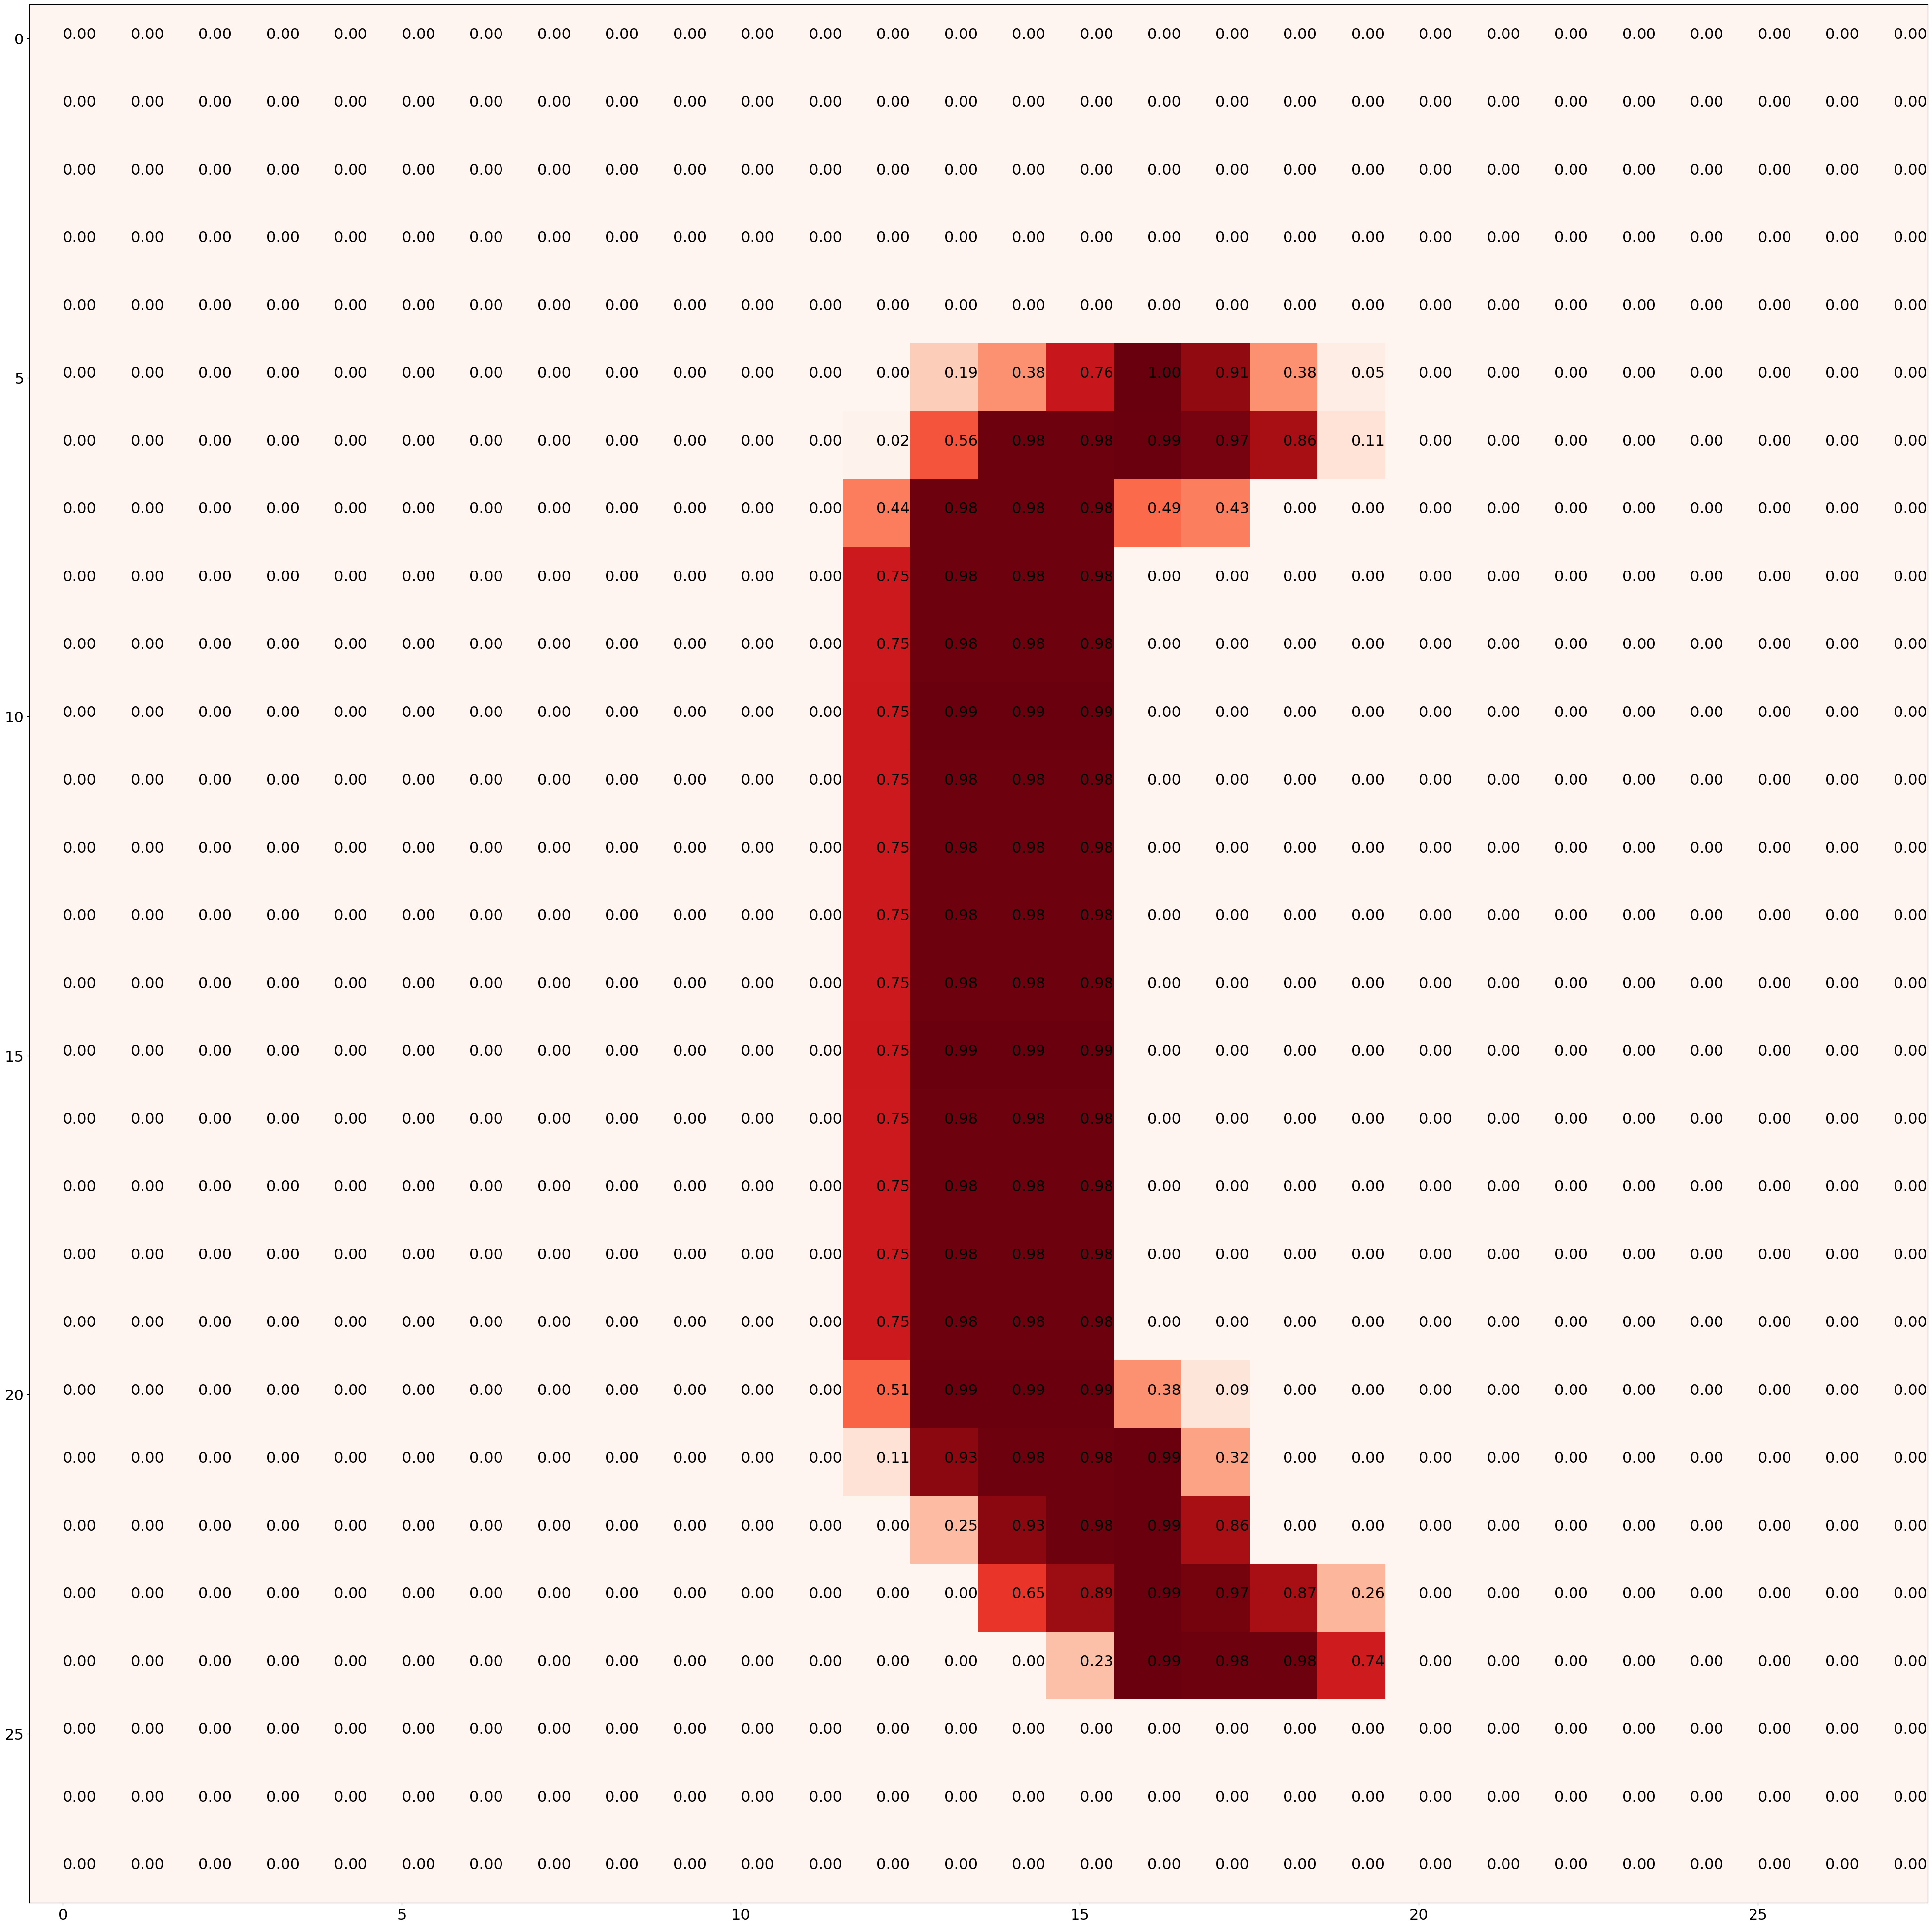

In [260]:
plt.figure(figsize=(50, 50))
image = next(iter(ds_train.take(1)))[0][0]
print(image[i, j][0].numpy())
fig = plt.imshow(image, cmap='Reds')
# fig.figsize((50, 50))
ax = fig.axes
font = {'size': 22}
plt.rc('font', **font)
for i in range(28):
    for j in range(28):
        text = ax.text(j, i, f"{image[i, j].numpy()[0]:.2f}")

Much better. We've got our datasets now, time to build and train a model

## Build the Model
For this exercise, we're going to build a basic model with three layers.

1. Flatten. From what we know about neurons they need a 1-dimensional input, not the 2D image we're about to feed it. The Flatten layer a 2D tensor as an input, and transforms it into a 1-D version. The Flatten layer is also our input layer, so we need to define the dimensions of our inputs to the network. In this case, it will be 28x28.
2. Dense (Hidden). This is our hidden layer. It is composed of 128 neurons, each being fed the flattened input tensor. They all have different weights they'll use for computation and training. 
3. Dense (Output). Another Dense layer, named so because each of the 10 neurons are connected to all 128 neurons of the previous layer. This gives us a total of 128*10=1280 weights for the network to use. We need 10 outputs because each will correspond to one of the digit classes. We'll look at whichever one is highest and use that as our prediction.

In [261]:
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation="softmax")
])

## Compile the Model

This is where we define our hyperparameters. Let's go through each one by one.
#### Optimizer - Stochastic Gradient Descent
Don't worry about the stochastic part for now, it's more or less the same gradient descent method we've used so far.
#### Learning Rate - 0.01
We already know about learning rate, just know that we use it as a parameter for the optimizer.
#### Loss - Sparse Categorical Crossentropy
Our accuracy is essentially a binary value, so mean squared error isn't going to help us. Categorical Crossentropy is a loss function that compares the true label to the 10 output values. We want the true value to be the highest value, and we also want the other possibilities to be as low a value as possible. "Sparse" just means our outputs are integers, not vectors. Don't worry about that part much.
#### Metrics - Sparse Categorical Accuracy
Previously we've just compared how close our linear regression guess was to the truth. That doesn't quite work here, but we can use a similar metric this time. We'll compare how close the predicted label is to the correct one. Ideally, we want the correct output to be 1 and the incorrect outputs to be 0.

In [262]:
model_1.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

## Fit the Model
Our model is built and compiled. Now we just need to put in our data and train it for a certain number of epochs. The Keras fit() function handles all of this for us, and can also give us live updates on how things are going.

In [263]:

model_1.summary()
model_1_history = model_1.fit(
    ds_train,
    epochs=10,
    validation_data=ds_test,
)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 784)               0         
                                                                 
 dense_59 (Dense)            (None, 128)               100480    
                                                                 
 dense_60 (Dense)            (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 68/469 [===>..........................] - ETA: 0s - loss: 2.0859 - sparse_categorical_accuracy: 0.3194  

2024-05-10 17:41:06.286293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [1]
	 [[{{node Placeholder/_2}}]]
2024-05-10 17:41:06.286597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
/opt/anaconda3/envs/tf/lib/python3.11/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


443/469 [===========================>..] - ETA: 0s - loss: 1.2284 - sparse_categorical_accuracy: 0.6995

2024-05-10 17:41:06.748439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2024-05-10 17:41:06.748755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]


469/469 [==============================] - 1s 1ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.7074 - val_loss: 0.6533 - val_sparse_categorical_accuracy: 0.8518
Epoch 2/10
469/469 [==============================] - 0s 830us/step - loss: 0.5606 - sparse_categorical_accuracy: 0.8606 - val_loss: 0.4603 - val_sparse_categorical_accuracy: 0.8834
Epoch 3/10
469/469 [==============================] - 0s 806us/step - loss: 0.4449 - sparse_categorical_accuracy: 0.8824 - val_loss: 0.3922 - val_sparse_categorical_accuracy: 0.8941
Epoch 4/10
469/469 [==============================] - 0s 814us/step - loss: 0.3939 - sparse_categorical_accuracy: 0.8924 - val_loss: 0.3573 - val_sparse_categorical_accuracy: 0.9036
Epoch 5/10
469/469 [==============================] - 0s 827us/step - loss: 0.3637 - sparse_categorical_accuracy: 0.8988 - val_loss: 0.3344 - val_sparse_categorical_accuracy: 0.9071
Epoch 6/10
469/469 [==============================] - 0s 831us/step - loss: 0.3426 - sparse_categorical

## Initial Results

We're already in a great spot! Our accuracy on our validation dataset, the one it wasn't trained on, is already over 92% in 10 epochs with a very simple model. To break down some of the terms used here:

sparse_categorical_accuracy and val_sparse_categorical_accuracy refer to the training accuracy and validation accuracy respectively. The same is true of loss and val_loss. The training values are used to help correct the model during backpropagation. The validation values are used by us to see how the model performs on data it hasn't seen yet. We can compare the two to see if the model is underfitting, not learning its data well enough, or overfitting, learning the training data *so* well that it doesn't adapt itself to validation data.

That said, this was our first stab, let's try a more complex model trained for a longer period of time.

In [264]:
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation="softmax")
])

model_2.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_2_history = model_2.fit(
    ds_train,
    epochs=50,
    validation_data=ds_test,
)

Epoch 1/50
469/469 [==============================] - 1s 1ms/step - loss: 1.4046 - sparse_categorical_accuracy: 0.6181 - val_loss: 0.6202 - val_sparse_categorical_accuracy: 0.8326
Epoch 2/50
469/469 [==============================] - 1s 1ms/step - loss: 0.4837 - sparse_categorical_accuracy: 0.8680 - val_loss: 0.3793 - val_sparse_categorical_accuracy: 0.8945
Epoch 3/50
469/469 [==============================] - 1s 1ms/step - loss: 0.3592 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.3188 - val_sparse_categorical_accuracy: 0.9075
Epoch 4/50
469/469 [==============================] - 1s 1ms/step - loss: 0.3133 - sparse_categorical_accuracy: 0.9098 - val_loss: 0.2860 - val_sparse_categorical_accuracy: 0.9169
Epoch 5/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2847 - sparse_categorical_accuracy: 0.9174 - val_loss: 0.2632 - val_sparse_categorical_accuracy: 0.9250
Epoch 6/50
469/469 [==============================] - 1s 1ms/step - loss: 0.2628 - sparse_categorica

## Staggering Improvements
Wow, that's way better. We're now at 97% accuracy. Surely a larger model with even more epochs would be even better!

In [265]:
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation="softmax")
])

model_3.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_3_history = model_3.fit(
    ds_train,
    epochs=100,
    validation_data=ds_test,
)

Epoch 1/100
469/469 [==============================] - 1s 2ms/step - loss: 1.9471 - sparse_categorical_accuracy: 0.3846 - val_loss: 0.9279 - val_sparse_categorical_accuracy: 0.7265
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 0.6124 - sparse_categorical_accuracy: 0.8110 - val_loss: 0.4382 - val_sparse_categorical_accuracy: 0.8677
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3956 - sparse_categorical_accuracy: 0.8820 - val_loss: 0.3413 - val_sparse_categorical_accuracy: 0.9009
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 0.3161 - sparse_categorical_accuracy: 0.9055 - val_loss: 0.2865 - val_sparse_categorical_accuracy: 0.9149
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 0.2678 - sparse_categorical_accuracy: 0.9204 - val_loss: 0.2424 - val_sparse_categorical_accuracy: 0.9274
Epoch 6/100
469/469 [==============================] - 1s 2ms/step - loss: 0.2329 - sparse_cate

## Maybe not...

Well that was underwhelming. Our accuracy didn't increase at all. What's more, our accuracy didn't even increase after epoch 25.

This is an important thing to consider. Your loss will almost always plateau at some point, and just adding more layers won't necessarily help learn more features. Let's go back to our second model and dig deeper into the results

## Results Analysis

<Axes: title={'center': 'Normalized History'}>

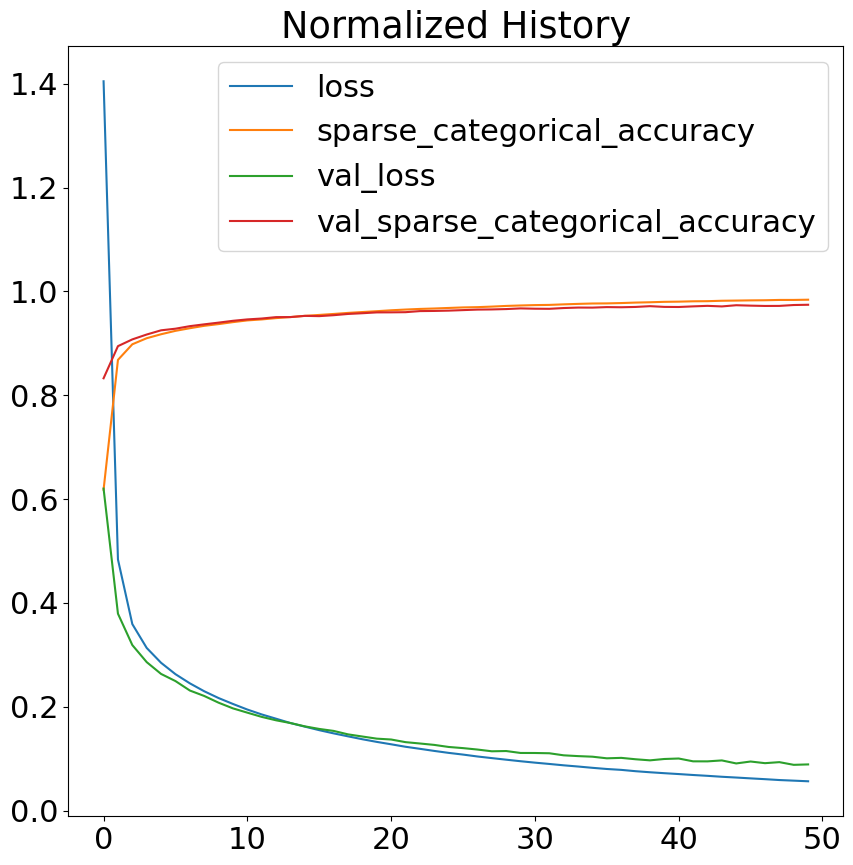

In [266]:
# Plot normalized data loss curves
import pandas as pd

pd.DataFrame(model_2_history.history).plot(title="Normalized History", figsize=(10, 10))

This kind of plot is helpful in two ways. 1, it shows us that our model was continuously improving, so our hyperparameters are at least okay. 2, and more importantly, we've got major diminishing returns after epoch 25 or so. We won't bother retraining, but if we wanted to iterate more we could probably save some time by stopping earlier. 

We've still got a 3% error rate. We can try to figure out where those errors are coming from with a confusion matrix. It's easier to just see what it is than explain it. 

In [267]:
# Create a confusion matrix

# Note: the confusion matrix code we're about to write is a remix of scikit-learns plot_confusion_matrix function

import itertools
from sklearn.metrics import confusion_matrix


def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
  # Create the confusion matrix
  cm = confusion_matrix(y_true, tf.round(y_pred))
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  # Lets prettify it
  fig, ax = plt.subplots(figsize=figsize)
  # Create a matrix plot
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  # Set labels to be classes
  if classes.any():
    labels=classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels)

  # Set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Adjust label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)
  # Set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment="center",
            color="white" if cm[i,j] > threshold else "black",
            size=text_size)
    
y_probs = model_2.predict(ds_test)
y_preds = y_probs.argmax(axis=1)

y_true = y = np.concatenate([y for x, y in ds_test], axis=0)

79/79 [==============================] - 0s 597us/step


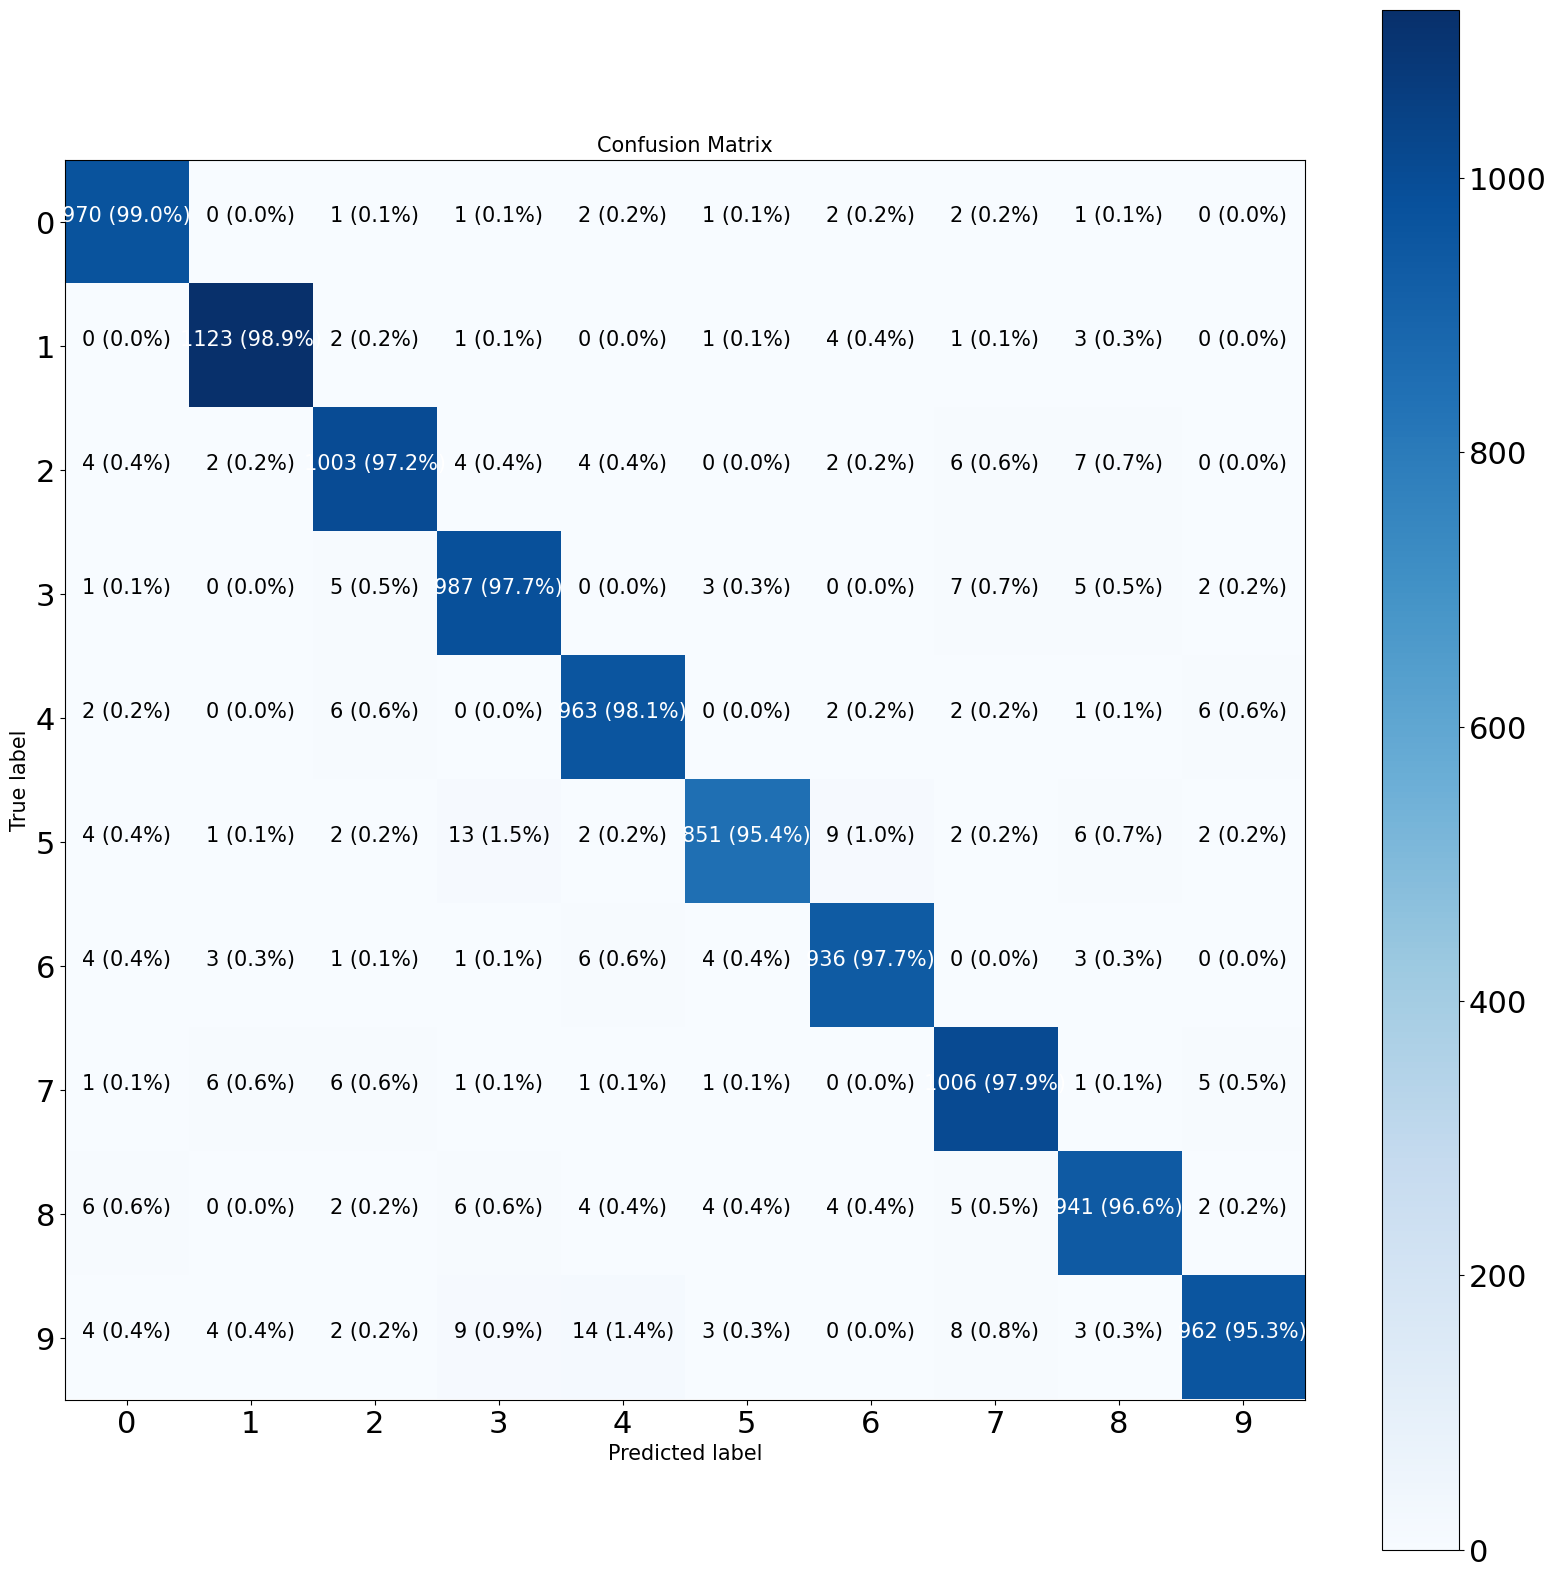

In [268]:
make_confusion_matrix(y_true = y_true,
                      y_pred= y_preds,
                      classes=np.arange(0, 10),
                      figsize=(20, 20),
                      text_size=15)

Our model is pretty solid, so we have to look pretty closel to find certain patterns. But we can tell for instance that 0, 1, and 2 have very high accuracy, while our model is getting confused by 4s and 9s sometimes. Which makes sense, there are lots of ways to write both in similar ways.

Lastly, lets visualize some examples and just to close the loop.

In [269]:
import random

def plot_random_image(model, images, true_labels, classes):
  """
  Picks a random image, plots it and labels it with a prediction and truth label.
  """

  # Set up random integer
  i = random.randint(0, len(images))

  # Create predictions and targets
  target_image = images[i]
  pred_probs = model.predict(target_image.reshape(1, 28, 28))
  
  print(np.around(pred_probs, 3))

  pred_label = classes[pred_probs.argmax()]
  true_label = classes[true_labels[i]]
  
  # Plot the image
  plt.imshow(target_image, cmap=plt.cm.binary)

  # Change the color of the titles depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Add xlabel information (prediction/true label)
  plt.xlabel("Pred: {} {:2.0f}% (True: {})".format(pred_label,
                                                 100*tf.reduce_max(pred_probs),
                                                 true_label),
           color=color) # Set the color to green or red based on if the prediction is right or wrong

1/1 [==============================] - 0s 23ms/step
[[0.    0.999 0.    0.    0.    0.    0.    0.001 0.    0.   ]]


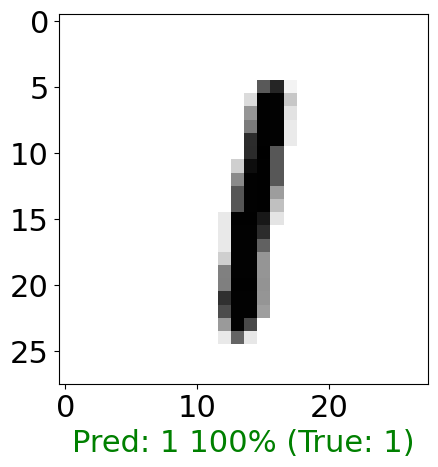

In [270]:
x = np.concatenate([x for x, y in ds_test], axis=0)
# Check out a random image as well as its prediction
plot_random_image(model=model_2,
                  images=x,
                  true_labels=y_true,
                  classes=np.arange(0, 10))

## Save the Model

We now have a model that we can use to predict handwritten digits with high accuracy (>97%). When we start building more complex neural networks, we'll want to save this one for later. Tensorflow once again makes this very easy for us.

In [271]:
model_2.save('MNIST_Dense_NN.keras')

loaded_model = tf.keras.models.load_model('MNIST_Dense_NN.keras')

loaded_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 784)               0         
                                                                 
 dense_61 (Dense)            (None, 128)               100480    
                                                                 
 dense_62 (Dense)            (None, 128)               16512     
                                                                 
 dense_63 (Dense)            (None, 128)               16512     
                                                                 
 dense_64 (Dense)            (None, 10)                1290      
                                                                 
Total params: 134,794
Trainable params: 134,794
Non-trainable params: 0
_________________________________________________________________


# Conclusion

In this notebook we:
* Used Tensorflow to import the MNIST dataset
* Normalized the images and optimized the dataset for high performance
* Built three neural networks of increasing complexity
* Trained each on the MNIST dataset and evaluated their performance
* Took the best and most simple model, analyzed its predictions, and saved it for later use